In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [6]:
sns.set(style='whitegrid')

In [7]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [38]:
df['isFraud'].value_counts(dropna=False)

,count
isFraud,
0,6354407
1,8213


In [11]:
df["isFlaggedFraud"].value_counts(dropna=False)

,count
isFlaggedFraud,
0,6362604
1,16


In [12]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [13]:
df.shape

(6362620, 11)

In [14]:
round(df['isFraud'].value_counts()[1]/df.shape[0] * 100, 1)

np.float64(0.1)

## VISUALIZING THE TRANSACTION TYPES


In [15]:
#pd.crosstab(df["type"], df['isFraud'])

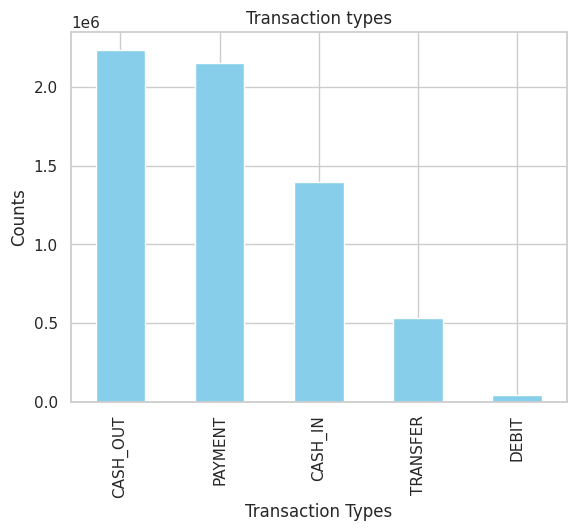

In [16]:
df["type"].value_counts().plot(kind='bar', title='Transaction types', color='skyblue')
plt.xlabel("Transaction Types")
plt.ylabel("Counts")
plt.show()



---

**Analysis:**

The dataset is dominated by CASH_OUT and PAYMENT transactions, followed by CASH_IN, while TRANSFER and especially DEBIT are much less frequent.

This imbalance suggests that fraud detection models must account for the skew, as most transactions are concentrated in just a few categories.

---



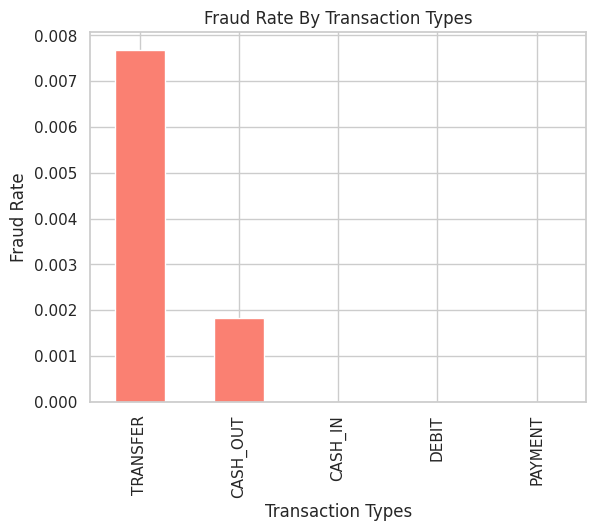

In [17]:
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', title='Fraud Rate By Transaction Types', color='salmon')
plt.xlabel("Transaction Types")
plt.ylabel("Fraud Rate")
plt.show()



---

**Analysis:**

Fraud occurs only in TRANSFER and CASH_OUT transactions, while CASH_IN, DEBIT, and PAYMENT show no fraud cases.

This suggests that TRANSFER and CASH_OUT should be prioritized for fraud detection and monitoring.

---



## Now let's go with amount statistics

In [18]:
df["amount"].describe().astype(int)

,amount
count,6362620
mean,179861
std,603858
min,0
25%,13389
50%,74871
75%,208721
max,92445516


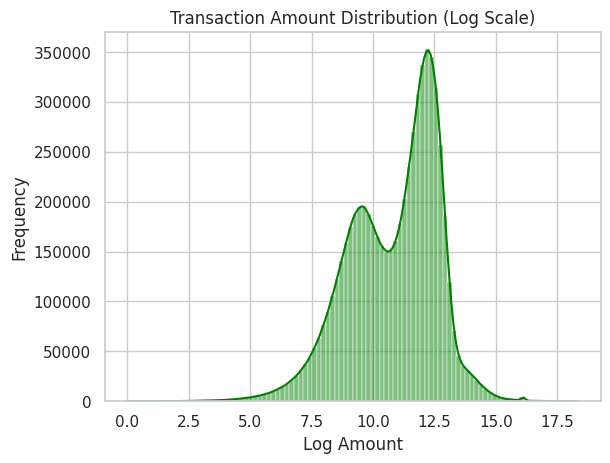

In [19]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color='green')
plt.title("Transaction Amount Distribution (Log Scale)")
plt.xlabel("Log Amount")
plt.ylabel("Frequency")
plt.show()



---

**Analysis**:

The transaction amounts are highly skewed, with two major clusters: one around 10k–20k and another around 150k–200k.
A smaller number of very large transactions (in the millions) also exist, visible as the long right tail.

---



**👉 General Rule**

Whenever you see a number on your log scale X-axis, just do:

That gives you the original transaction amount. ✅

In [20]:
import numpy as np
real_amount=np.expm1(9)
print(f"{real_amount:.0f}")

8102


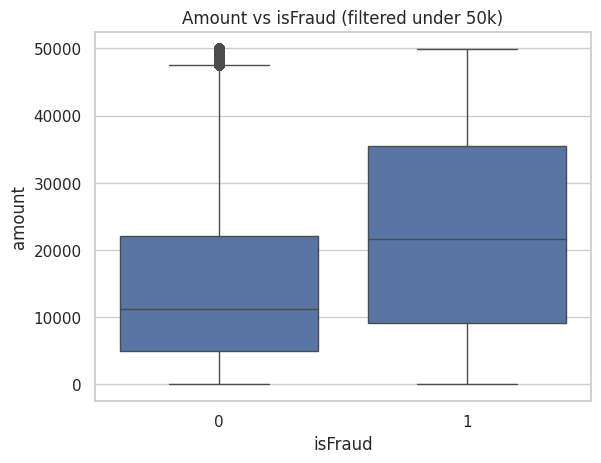

In [21]:
sns.boxplot(data=df[df['amount']<50000], x='isFraud', y='amount')
plt.title("Amount vs isFraud (filtered under 50k)")
plt.show()



---

Fraudulent transactions generally involve higher amounts, with their median value nearly double that of non-fraudulent ones.

---



In [22]:
df['balanceDiffOrig']=df['oldbalanceOrg']-df['newbalanceOrig']
df['balanceDiffDest']=df['newbalanceDest']-df['oldbalanceDest']

* balanceDiffOrig → how much money should have left the origin account.
Ideally: oldbalanceOrg - newbalanceOrig = transaction amount

* balanceDiffDest → how much money should have been added to the destination account.
Ideally: oldbalanceDest - newbalanceDest = transaction amount

In [23]:
(df['balanceDiffOrig']<0).sum()

np.int64(1399253)

In [24]:
(df['balanceDiffDest']<0).sum()

np.int64(1238864)

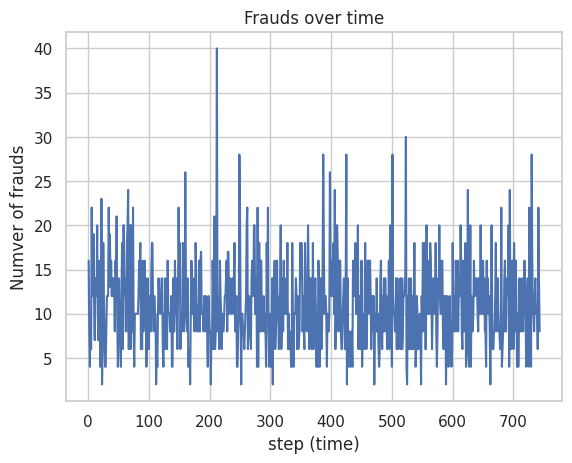

In [25]:
fraud_per_step=df[df['isFraud']==1]['step'].value_counts().sort_index()
plt.plot(fraud_per_step.index, fraud_per_step.values, label='Fraud per Step')
plt.xlabel("step (time)")
plt.ylabel('Numver of frauds')
plt.title('Frauds over time')
plt.show()




---

This graph tells us: fraud happens steadily over time, with occasional spikes but no big trend. Even if it doesn’t give strong insights, plotting it ensures we don’t miss hidden patterns.

---



In [26]:
df.drop(columns=['step'], inplace=True)

In [27]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [28]:
top_senders=df['nameOrig'].value_counts().head(10)

In [29]:
top_senders

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
C1462946854,3
C1065307291,3
C1999539787,3
C2098525306,3


In [30]:
top_receivers=df['nameDest'].value_counts().head(10)

In [31]:
top_receivers

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
C1590550415,101
C1789550256,99
C451111351,99
C1360767589,98


In [32]:
fraud_users=df[df['isFraud']==1]['nameOrig'].value_counts().head(10)

In [33]:
fraud_users

,count
nameOrig,
C1280323807,1
C1305486145,1
C840083671,1
C1420196421,1
C2101527076,1
C1039979813,1
C2089752665,1
C1614818636,1
C40604503,1




---

Fraudulent transactions are distributed across many different users, with no sender appearing more than once in the top 10 fraud cases. This suggests fraud is not concentrated to a few high-frequency accounts, but is instead widespread.

---



In [34]:
fraud_types=df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [35]:
fraud_types.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [36]:
fraud_types['type'].value_counts()

,count
type,
CASH_OUT,2237500
TRANSFER,532909


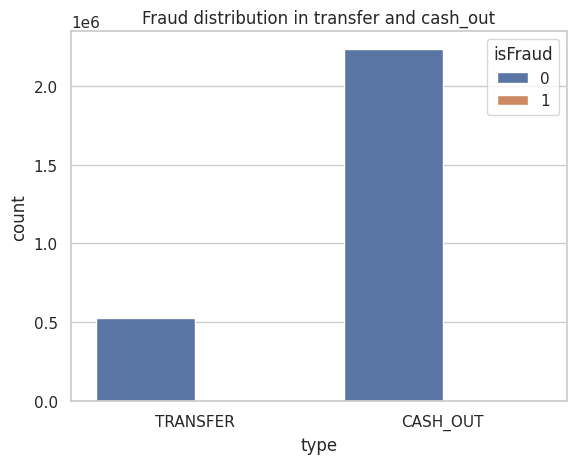

In [39]:
sns.countplot(data=fraud_types, x='type', hue='isFraud')
plt.title('Fraud distribution in transfer and cash_out')
plt.xlabel('type')
plt.ylabel('count')
plt.show()



---

**In short, the analysis is:**

🔹 Fraudulent transactions occur only in TRANSFER and CASH_OUT types.

🔹 But the vast majority of these transactions are non-fraudulent → fraud cases are extremely rare compared to normal ones.

🔹 This shows a class imbalance problem, which is important to keep in mind when building a fraud detection model.

---



In [42]:
corr=df[['amount',"oldbalanceOrg", 'newbalanceOrig', 'oldbalanceDest', "newbalanceDest", 'isFraud']].corr()


In [43]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


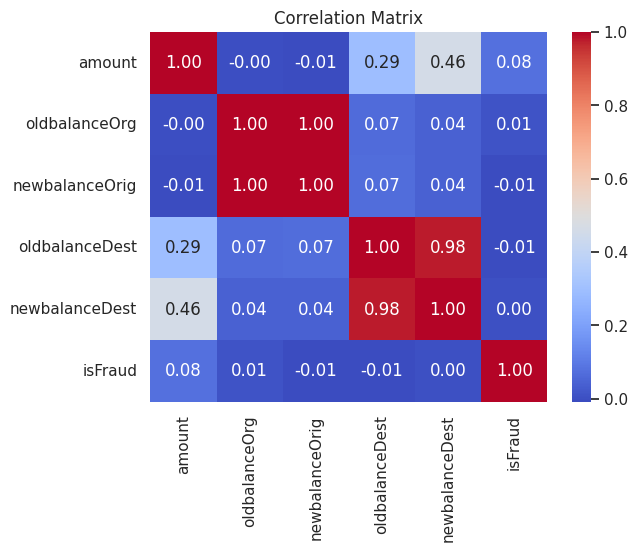

In [47]:
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f' )
plt.title("Correlation Matrix")
plt.show()



---
**Correlations with isFraud**

* amount (0.08) → Very weak positive relation → higher amounts slightly more likely to be fraud.

* oldbalanceOrg (0.01) → Almost no relation → origin balance doesn’t help much in detecting fraud.

* newbalanceOrig (-0.01) → Almost no relation → fraud doesn’t depend on sender’s new balance.

* oldbalanceDest (-0.01) → Almost no relation → fraud not tied to receiver’s old balance.

* newbalanceDest (0.00) → No relation at all → useless for fraud detection.

* isFraud (1.00) → Perfect correlation with itself (always true).

*Among all these, amount is the only feature with even a tiny correlation (0.08) with fraud, while the others have negligible or no linear relationship.*

---



In [52]:
# filter customers who have balance and after transfer they go zero

zero_after_tarnsfer=df[
    (df['oldbalanceOrg']>0) & (df['newbalanceOrig']==0) & (df['type'].isin(['TRANSFER', "CASH_OUT"]))
]

In [54]:
len(zero_after_tarnsfer)

1188074

In [55]:
zero_after_tarnsfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [56]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


## **NOW WE'LL MOVE ON TO FEATURE SELECTION**

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import  Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [58]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [60]:
df_model=df.drop(columns=['nameOrig','nameDest', 'isFlaggedFraud'])

In [61]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [66]:
categorical=['type']
numeric=['amount',	'oldbalanceOrg',	'newbalanceOrig',	'oldbalanceDest',	'newbalanceDest']

In [64]:
y=df_model['isFraud']
X=df_model.drop(columns=['isFraud'])

In [65]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y)

In [70]:
preprocessor=ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(), categorical)

        ],
    remainder="drop"
)

In [73]:
# Create model pipeline

pipeline=Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

In [75]:
# train the model with  preprocessing

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', OneHotEncoder(),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [76]:
y_pred=pipeline.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.95      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786





---

“Model detects 95% of real frauds but misses 5%, and almost all of its fraud predictions (98%) are actually non-fraud, leading to many false alarms.”

It clearly highlights both missed frauds and low precision.

---



In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

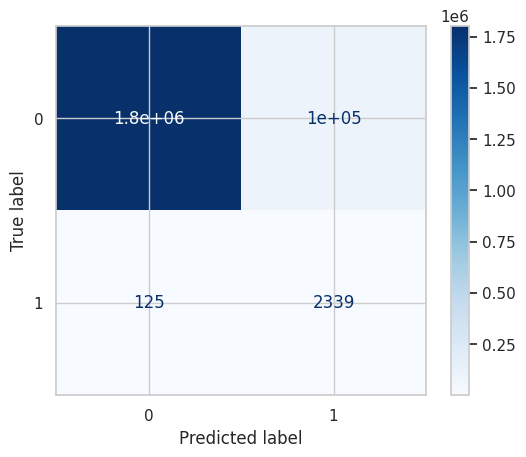

In [85]:
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()

In [86]:
print(cm)

[[1804113  102209]
 [    125    2339]]


In [88]:
pipeline.score(X_test, y_test)*100

94.6387913574387

In [89]:
# Time for exporting this pipeline

import joblib
joblib.dump(pipeline, "fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']